# California Recall Simulation - Visualizing the Results

In [16]:
from pref_voting.voting_methods import *
from pref_voting.generate_spatial_profiles import *

import numpy as np
import pandas as pd

from multiprocess import Pool, cpu_count

import matplotlib.pyplot as plt
import seaborn as sns

import os

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D


In [17]:

def plot_conditional_for_opponents(
    df,
    x_labels,
    title,
    filename,
    x_col='concentration_parameter',
    opp_col='num_cands_opposition_party',
    y_col='conditional_pr_incumbent_maj_pref_winner_after_recall',
    err_col='err_conditional_pr_incumbent_maj_pref_winner_after_recall'
):
    fontsize = 12
    plt.figure(figsize=(8, 7))

    # 1) auto-detect all opponent sizes and sort
    opponent_sizes = sorted(df[opp_col].unique())
    n = len(opponent_sizes)

    # 2) pick a qualitative palette, plus a set of linestyles & markers
    colors     = sns.color_palette("tab10", n_colors=n)
    linestyles = ['-', '--', '-.', ':']
    markers    = ['o', 's', '^', 'D', 'v', 'P', 'X', '*']

    for i, opp in enumerate(opponent_sizes):
        df_sub = df[df[opp_col] == opp]
        if df_sub.empty:
            continue

        y_col = 'conditional_pr_incumbent_maj_pref_winner_after_recall'
        err_col = 'err_conditional_pr_incumbent_maj_pref_winner_after_recall'

        # aggregate & reindex as before
        agg = (
            df_sub.groupby(x_col)[[y_col, err_col]]
                  .mean()
                  .reindex(x_labels)
        )
        agg[y_col] = agg[y_col].ffill().bfill()
        agg[err_col] = agg[err_col].fillna(0.0)

        x = np.arange(len(x_labels))
        y = agg[y_col].to_numpy()
        e = agg[err_col].to_numpy()

        # pick style for this index
        c  = colors[i]
        ls = linestyles[i % len(linestyles)]
        mk = markers[i % len(markers)]

        plt.plot(
            x, y,
            #marker=mk,
            #linestyle=ls,
            color=c,
            label=f'{opp}'
        )
        plt.fill_between(
            x,
            y - e,
            y + e,
            alpha=0.2,
            color=c
        )


        # top lines
        y_col = 'pr_recall'
        err_col = 'err_recall_events'
        # aggregate & reindex as before
        agg = (
            df_sub.groupby(x_col)[[y_col, err_col]]
                  .mean()
                  .reindex(x_labels)
        )
        agg[y_col] = agg[y_col].ffill().bfill()
        agg[err_col] = agg[err_col].fillna(0.0)

        x = np.arange(len(x_labels))
        y = agg[y_col].to_numpy()
        e = agg[err_col].to_numpy()

        # pick style for this index
        c  = colors[i]
        ls = linestyles[i % len(linestyles)]
        mk = markers[i % len(markers)]

        plt.plot(
            x, y,
            #marker=mk,
            linestyle='--',
            color=c,
        )
        plt.fill_between(
            x,
            y - e,
            y + e,
            alpha=0.2,
            color=c
        )

    # formatting
    formatted = [str(int(l)) if l == int(l) else str(l) for l in x_labels]
    plt.xticks(np.arange(len(x_labels)), formatted, rotation=0, fontsize=fontsize)
    plt.yticks(np.arange(0.0, 1.1 , 0.1), fontsize=fontsize)
    plt.xlabel('Concentration Parameter $\\lambda$', fontsize=fontsize)
    plt.ylabel('Probability', fontsize=fontsize)
    plt.ylim(-0.01, 1)
    
    # --- LEGEND 1: colored lines (opponent sizes) ---
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # set title font to fontsize

    leg1 = ax.legend(
        handles, labels,
        title="Number of candidates in the non-incumbent party",
        title_fontsize = fontsize,
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.665, 1.295),   
        fontsize=fontsize,
        ncol=4
    )
    ax.add_artist(leg1)

    # --- LEGEND 2: style key ---
    solid_key  = Line2D([0], [0], color='black', linestyle='-',  label='Majority prefers incumbent to replacement, conditional on a recall')
    dashed_key = Line2D([0], [0], color='black', linestyle='--', label='Recall')
    # move legend down 
    plt.legend(
        handles=[dashed_key, solid_key],
        frameon=False,
        loc='upper center',
        bbox_to_anchor=(0.45, 1.14),   
        fontsize=fontsize
    )
    
    plt.title(title, fontsize=fontsize, y=1.3)
    sns.despine()
    plt.grid(False)
    plt.tight_layout()

    plt.savefig(filename)
    plt.show()


Processing files from data/inc3/55_45


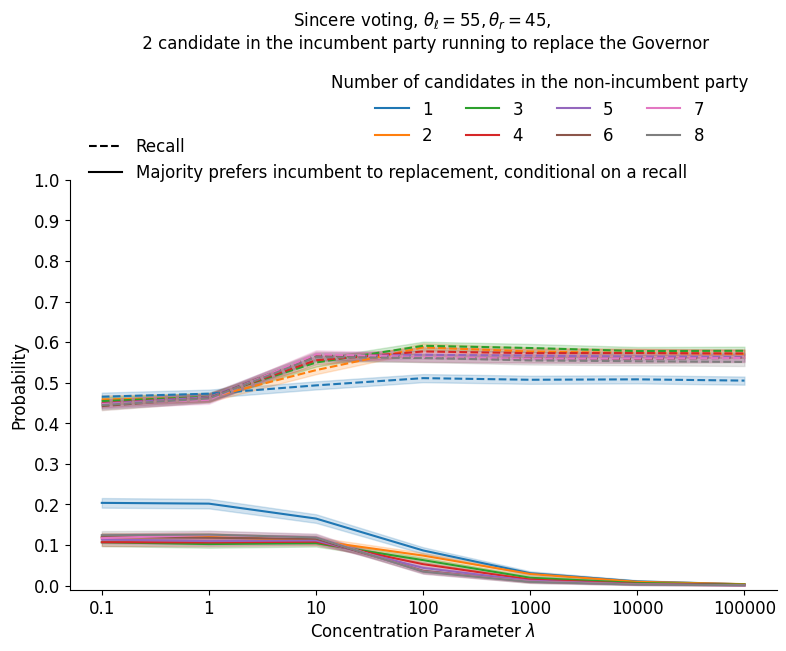

In [19]:

theta_l, theta_r = 55, 45 #5, 5 # 55, 45 # 45, 55
num_incumbent_cands = 3 #3 #4
manipulation_level = 1.0
recall_decision_type = 'sincere' #'sincere' #'strategic'
replacement_rule = 'sincere' #'sincere' 'strategic-top-two'

main_dir='data' #'multiple_candidates2'
sub_dir = f'inc{num_incumbent_cands}/{theta_l}_{theta_r}'  

if recall_decision_type == 'sincere':
    initial_title = f'Sincere voting, $\\theta_\ell={theta_l}, \\theta_r={theta_r}$, '
else: 
    initial_title = f'Strategic voting, manipulation level ${int(manipulation_level)}$, $\\theta_\ell={theta_l}, \\theta_r={theta_r}$, '
#'strategic-top-two'
opponent_sizes = [1, 2, 3, 4, 5, 6, 7, 8]
std_str        = '0.5'

# 2) Read & concatenate
all_dfs = []
print(f"Processing files from {main_dir}/{sub_dir}")
for opp in opponent_sizes:
    pattern = f'{main_dir}/{sub_dir}/recall_data_{manipulation_level}_{recall_decision_type}_{replacement_rule}_*_{std_str}_{num_incumbent_cands}_{opp}.csv'
    for fp in glob.glob(pattern):
        df_tmp = pd.read_csv(fp)
        # annotate each row with the opponent‐size
        df_tmp['num_cands_opposition_party'] = opp
        all_dfs.append(df_tmp)

# 3) glue them together
df = pd.concat(all_dfs, ignore_index=True).drop_duplicates()

num_incumbent_cands = df["num_cands_incumbent_party"].unique()

if len(num_incumbent_cands) > 1: 
    print(f"Warning: More than one number of incumbent candidates: {num_incumbent_cands}")
else: 
    num_incumbent_cands = num_incumbent_cands[0]

title = f'{initial_title}\n {num_incumbent_cands - 1} candidate in the incumbent party running to replace the Governor'
CONC_PARAMS = [0.1, 1.0, 10.0, 100.0, 1e3, 1e4, 1e5]
OUTFILE     = f'graphs/{num_incumbent_cands}_{theta_l}_{theta_r}_{recall_decision_type}_{replacement_rule}_{manipulation_level}.pdf'

plot_conditional_for_opponents(
    df,
    x_labels=CONC_PARAMS,
    title = title,
    filename=OUTFILE
)
